In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("./MNIST_data")

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


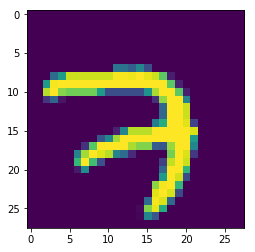

In [4]:
plt.imshow(mnist.train.images[0].reshape(28, 28))

In [5]:
def generator(z, reuse=None):
    """
    z: input with random noise
    """
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(z, 128, activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(hidden1, 128, activation=tf.nn.leaky_relu)
        output = tf.layers.dense(hidden2, 784, activation=tf.nn.tanh)
        return output

In [6]:
def discriminator(X, reuse=None):
    """
    z: input with random noise
    """
    with tf.variable_scope('dis', reuse=reuse):
        hidden1 = tf.layers.dense(X, 128, activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(hidden1, 128, activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(hidden2, 1)
        output = tf.sigmoid(logits)
        return output, logits

In [7]:
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

In [8]:
G = generator(z)

In [9]:
D_output_real, D_logits_real = discriminator(real_images)

In [10]:
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

In [11]:
# losses

def loss_func(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

In [12]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real) * 0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)

In [18]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [19]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [20]:
g_vars

[<tf.Variable 'gen/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/bias:0' shape=(784,) dtype=float32_ref>]

In [21]:
batch_size = 100
epochs = 30

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
samples = []

In [24]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [25]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        num_batches = mnist.train.num_examples // batch_size
        
        for _ in range(num_batches):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # rescale images
            batch_images = batch_images * 2 - 1
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            sess.run(G_trainer, feed_dict={z: batch_z})

        print(f"On Epoch {epoch}")
        
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
        
        samples.append(gen_sample)
    
    saver.save(sess, "./models/GAN")

On Epoch 0
On Epoch 1
On Epoch 2
On Epoch 3
On Epoch 4
On Epoch 5
On Epoch 6
On Epoch 7
On Epoch 8
On Epoch 9
On Epoch 10
On Epoch 11
On Epoch 12
On Epoch 13
On Epoch 14
On Epoch 15
On Epoch 16
On Epoch 17
On Epoch 18
On Epoch 19
On Epoch 20
On Epoch 21
On Epoch 22
On Epoch 23
On Epoch 24
On Epoch 25
On Epoch 26
On Epoch 27
On Epoch 28
On Epoch 29


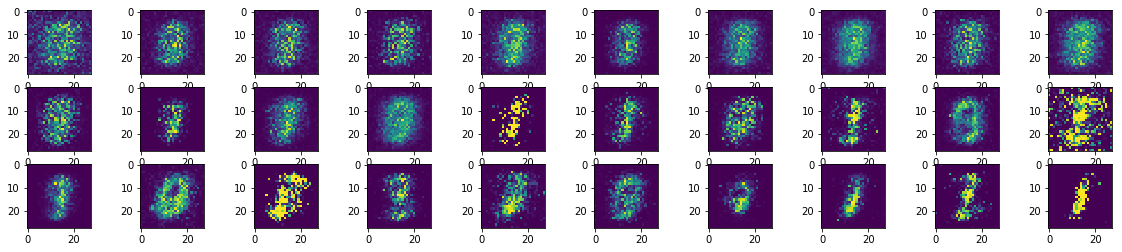

In [26]:
f, a = plt.subplots(3, 10, figsize=(20, 4))
for index, value in enumerate(samples):
    a[index // 10][index % 10].imshow(value.reshape(28, 28))

In [27]:
saver = tf.train.Saver(var_list=g_vars)

In [28]:
new_samples = []

with tf.Session() as sess:
    saver.restore(sess, "./models/500_epoch_model.ckpt")
    
    for x in range(30):
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./models/500_epoch_model.ckpt


In [29]:
len(new_samples)

30

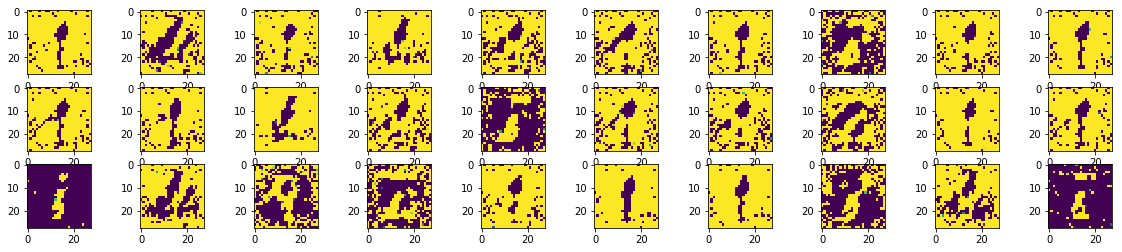

In [30]:
f, a = plt.subplots(3, 10, figsize=(20, 4))
for index, value in enumerate(new_samples):
    a[index // 10][index % 10].imshow(value.reshape(28, 28))